In [3]:
import pandas as pd
import numpy as np
import ast
import json
import re
from collections import defaultdict

In [4]:
df = pd.read_csv('data/final_dataset_reduced.csv')
print(len(df))

32028


In [5]:
default_social_tags = {
 "Ariana Grande" : "pop",
 "BTS (방탄소년단)": "pop",
 "Beyoncé": "rnb",
 "Billie Eilish": "indie pop",
 "Cardi B": "hip-hop",
 "Charlie Puth": "pop",
 "Coldplay": "alternative rock",
 "Drake": "hip-hop",
 "Dua Lipa": "pop",
 "Ed Sheeran": "pop",
 "Eminem": "hip-hop",
 "Justin Bieber": "pop",
 "Katy Perry": "pop",
 "Khalid": "rnb",
 "Lady Gaga": "pop",
 "Maroon5": "pop",
 "Nicki Minaj": "hip-hop",
 "Post Malone": "hip-hop",
 "Rihanna": "rnb",
 "Selena Gomez": "pop",
 "Taylor Swift": "pop"
}

In [6]:
dataset_dict_list = df.to_dict('records')

with open('data/good_tags.json', 'r') as fp:
    good_tags = set(json.load(fp))
    

In [7]:
# dict of tags for each song as a weighted string ie. ["pop pop pop pop", "hip-hop, hip-hop"]
weighted_list_of_str_tags = []

for song_index, row in enumerate(dataset_dict_list):

    song_social_tags = ast.literal_eval(row['social_tags']) if not pd.isna(row['social_tags']) else []
    song_emotion_tags = ast.literal_eval(row['emotion_tags']) if not pd.isna(row['emotion_tags']) else []

    # add default social tag to 21 artists
    if row['artist'] in default_social_tags and len(song_social_tags) == 0:
        song_social_tags = [(default_social_tags[row['artist']], 100)]

    weighted_tags_list = []

    for tag, value in (song_social_tags + song_emotion_tags):
        if tag in good_tags:
            # add the number of tags * (value // 10)
            for i in range(value // 10):
                weighted_tags_list.append(re.sub(r'\W+', '', tag))
    
    weighted_list_of_str_tags.append(" ".join(weighted_tags_list))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
vectorizer = TfidfVectorizer()
td_matrix = vectorizer.fit_transform(weighted_list_of_str_tags)

In [10]:
# feature_names = vectorizer.get_feature_names() 
# feature_names


In [11]:
from scipy.sparse.linalg import svds
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u,s,v_trans = svds(td_matrix, k=168)

In [12]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(32028, 168)
(168,)
(168, 169)


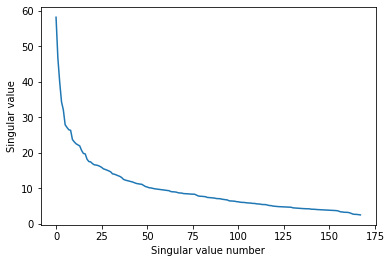

In [13]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [14]:
# these should be the three output matrices -> not sure if rest of code is important (normalization)
songs_compressed, s, tags_compressed = svds(td_matrix, k=10)
tags_compressed = tags_compressed.transpose()

In [15]:
print(songs_compressed)

[[ 4.16373898e-03  3.18593782e-02 -6.14433769e-03 ... -3.01546253e-04
  -1.06823596e-05  2.91452438e-04]
 [ 4.16373898e-03  3.18593782e-02 -6.14433769e-03 ... -3.01546253e-04
  -1.06823596e-05  2.91452438e-04]
 [ 4.16373898e-03  3.18593782e-02 -6.14433769e-03 ... -3.01546253e-04
  -1.06823596e-05  2.91452438e-04]
 ...
 [ 1.12308500e-02 -1.76289223e-03  2.58749539e-03 ...  3.50337261e-04
   1.16972860e-02  1.83567156e-03]
 [ 8.32442828e-03  3.68141722e-04  1.10335167e-02 ...  2.77043520e-04
   8.89630046e-03  1.30191445e-03]
 [ 1.12744140e-02 -3.68619152e-03 -5.57798557e-03 ...  3.10674925e-04
   9.55362342e-03  3.42927354e-03]]


In [16]:
# x = np.matmul(songs_compressed, s)
# print(x.shape)
# print(tags_compressed.shape)
# x = np.matmul(tags_compressed, x )


In [17]:
# print("SVD matrix 1 (songs vs new tags)")
# print(songs_compressed.shape)
# print("SVD matrix 2")
# print(s.shape)
# print("SVD matrix 3: old tags x new tags")
# print(tags_compressed.shape)
# print("matrix multiplication dimensions")
# songsXtags = songs_compressed @ tags_compressed.T
# print(songsXtags.shape)



In [18]:
# print(tags_compressed.shape)
# print(songs_compressed.shape)
# print(len(dataset_dict_list))

In [19]:
def normalize(l):
  normalized = []
  for x in l:
    normalized.append((x - min (l) )/(max(l) - min(l)))

  return normalized

In [20]:
np.apply_along_axis(normalize, 1, songs_compressed)

/Users/fjordrunner/cs4300-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


array([[0.41377673, 1.        , 0.19558952, ..., 0.31926171, 0.32541831,
        0.33181349],
       [0.41377673, 1.        , 0.19558952, ..., 0.31926171, 0.32541831,
        0.33181349],
       [0.41377673, 1.        , 0.19558952, ..., 0.31926171, 0.32541831,
        0.33181349],
       ...,
       [0.98466132, 0.55736405, 0.7004259 , ..., 0.62685729, 1.        ,
        0.67570228],
       [0.90450428, 0.62404414, 1.        , ..., 0.62083291, 0.92466285,
        0.65695975],
       [1.        , 0.43935466, 0.3684601 , ..., 0.58913633, 0.93551376,
        0.70600512]])

In [25]:
s_matrix = np.diag(s)
US = songs_compressed @ (s_matrix ** 0.5)
print(s_matrix.shape)
print(US.shape)
print(US)

(10, 10)
(32028, 10)


In [118]:
training_json = dict()

for tag_scores, song_dict, weighted_tag_string in zip(songs_compressed, dataset_dict_list, weighted_list_of_str_tags):
    weighted_tag_list = weighted_tag_string.split()
    if len(weighted_tag_list) > 9:
        training_song_data = dict()
        training_song_data["lyrics"] = song_dict['lyrics']
        training_song_data["tag_list"] = tag_scores.tolist()
        song_title = song_dict["title"]
        training_json[song_title] = training_song_data


In [119]:
print(len(training_json))

23524


In [120]:
with open('../nlp/songs_training_data.json', 'w') as fp:
    json.dump(training_json, fp)

In [70]:
# word_to_index = vectorizer.vocabulary_
# index_to_word = {i:t for t,i in word_to_index.items()}
# print(tags_compressed.shape)

In [71]:
# from sklearn.preprocessing import normalize
# words_compressed_normed = normalize(tags_compressed, axis = 1)

In [54]:
# def closest_words(word_in, words_representation_in, k = 10):
#     if word_in not in word_to_index: return "Not in vocab."
#     sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
#     asort = np.argsort(-sims)[:k+1]
#     return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [ ]:
# td_matrix_np = td_matrix.transpose().toarray()
# td_matrix_np = normalize(td_matrix_np)